<a href="https://colab.research.google.com/github/Subtlr/breast_cancer_prediction/blob/main/breast_cancer_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Data and Modules

In [ ]:
!pip install opendatasets --quiet

In [ ]:
import opendatasets as od

In [ ]:
od.download(r"https://www.kaggle.com/datasets/wasiqaliyasir/breast-cancer-dataset")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

plt.style.use("dark_background")

In [ ]:
df_unmodified = pd.read_csv(r"/content/breast-cancer-dataset/Breast_cancer_dataset.csv")

In [ ]:
df_unmodified

# Data Preprocessing

In [ ]:
df_unmodified.drop(columns='Unnamed: 32', inplace=True)

In [ ]:
df_unmodified.isna().sum()

In [ ]:
X, y = df_unmodified.drop(columns=['diagnosis', 'id']), df_unmodified['diagnosis']

In [ ]:
y.value_counts()["B"]

In [ ]:
import imblearn as imb

In [ ]:
def preprocess_data(X, y):
  smote = imb.over_sampling.SMOTE(random_state=36)
  X_resampled, y_resampled = smote.fit_resample(X, y)
  print(f"Class Amounts: {y_resampled.value_counts().iloc[0]} and {y_resampled.value_counts().iloc[1]}")

  X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=36)
  X_train, X_val, y_train, y_val = skl.model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=36)

  return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data(X, y)

In [ ]:
def standardize_data(X_train, X_val, X_test):
  scaler = skl.preprocessing.StandardScaler()

  scaler.fit(X_train)
  X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
  X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
  X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

  return X_train, X_val, X_test

In [ ]:
X_train, X_val, X_test = standardize_data(X_train, X_val, X_test)

In [ ]:
X_train

In [ ]:
plt.figure(figsize=(30,20))
sns.heatmap(X_train.corr(), cmap="coolwarm")

In [ ]:
def combine_3_features(X_train, X_val, X_test, col1, col2, col3, delete:bool):
  X_train[f'{col1}_{col2}_{col3}_mean'] = X_train[[col1, col2, col3]].mean(axis=1)
  X_val[f'{col1}_{col2}_{col3}_mean'] = X_val[[col1, col2, col3]].mean(axis=1)
  X_test[f'{col1}_{col2}_{col3}_mean'] = X_test[[col1, col2, col3]].mean(axis=1)

  if delete == True:
    X_train.drop(columns=[col1, col2, col3], inplace=True)
    X_val.drop(columns=[col1, col2, col3], inplace=True)
    X_test.drop(columns=[col1, col2, col3], inplace=True)
  else: pass

  return X_train, X_val, X_test

In [ ]:
X_train, X_val, X_test = combine_3_features(X_train, X_val, X_test, 'radius_mean', 'perimeter_mean', 'area_mean', delete=True)
X_train, X_val, X_test = combine_3_features(X_train, X_val, X_test, 'radius_worst', 'perimeter_worst', 'area_worst', delete=True)

In [ ]:
rename_hash = {
    "radius_mean_perimeter_mean_area_mean_mean": "rpa_mean",
    "radius_worst_perimeter_worst_area_worst_mean": "rpa_worst"
}

In [ ]:
X_train.rename(columns=rename_hash, inplace=True)
X_val.rename(columns=rename_hash, inplace=True)
X_test.rename(columns=rename_hash, inplace=True)

In [ ]:
X_train

In [ ]:
plt.figure(figsize=(30,20))
sns.heatmap(X_train.corr(), cmap="coolwarm")

# Machine Learning

## Logistic Regression

In [ ]:
X_train.shape

In [ ]:
logistician = skl.linear_model.LogisticRegressionCV(cv=5, scoring="recall", verbose=True)

In [ ]:
logistician.fit(X_train, y_train)

In [ ]:
log_y_preds = logistician.predict(X_val)
log_y_probas = logistician.predict_proba(X_val)

In [ ]:
log_betas = pd.DataFrame(logistician.coef_, columns=X_train.columns)
log_betas.head()

In [ ]:
plt.figure(figsize=(30,20))
sns.barplot(data=log_betas.sort_values(by=0, axis=1), orient="h")
plt.grid(axis="x", c="white")
plt.show()

In [ ]:
def model_evaluation(y_val, y_preds, y_probas):

  # Evaluate the model on the validation set
  log_precision = skl.metrics.precision_score(y_val, y_preds, pos_label='B') # Assuming 'M' is the positive class
  log_recall = skl.metrics.recall_score(y_val, y_preds, pos_label='B')
  log_f1 = skl.metrics.f1_score(y_val, y_preds, pos_label='B')
  log_bceloss = skl.metrics.log_loss(y_val, y_probas)

  print(f"Validation Precision: {log_precision:.4f}")
  print(f"Validation Recall: {log_recall:.4f}")
  print(f"Validation F1-score: {log_f1:.4f}")
  print(f"Validation BinaryCrossEntropy Loss: {log_bceloss:.4f}")

  # Display confusion matrix
  log_conf_matrix = skl.metrics.confusion_matrix(y_val, y_preds, labels=['M', 'B'])
  print("\nConfusion Matrix:")
  print(log_conf_matrix) # Specify labels to ensure correct order

  # Display classification report
  print("\nClassification Report:")
  print(skl.metrics.classification_report(y_val, y_preds))

  return log_conf_matrix

In [ ]:
log_conf_matrix = model_evaluation(y_val, log_y_preds, log_y_probas)

In [ ]:
sns.heatmap(log_conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xticks([0.5, 1.5], ['Benign', 'Malignant'])
plt.yticks([0.5, 1.5], ['Benign', 'Malignant'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

## Random Forests

In [ ]:
forest = skl.ensemble.RandomForestClassifier(n_estimators=50, max_leaf_nodes=40, max_depth=4, verbose=1, n_jobs=-1, class_weight='balanced')

In [ ]:
forest.fit(X_train, y_train)

In [ ]:
forest_y_preds = forest.predict(X_val)
forest_y_probas = forest.predict_proba(X_val)

In [ ]:
forest_y_preds

In [ ]:
y_val.values

In [ ]:
forest_conf_matrix = model_evaluation(y_val, forest_y_preds, forest_y_probas)

In [ ]:
def confusion_matrix_heatmap(conf_matrix, title:str):
  sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
  plt.xticks([0.5, 1.5], ['Good', 'Bad'])
  plt.yticks([0.5, 1.5], ['Good', 'Bad'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title(title)
  plt.show()

In [ ]:
confusion_matrix_heatmap(forest_conf_matrix, "Random Forest Confusion Matrix")

In [ ]:
forest_betas = pd.DataFrame(forest.feature_importances_, index=X_train.columns, columns=["Importance"]).sort_values(by="Importance", ascending=False)

In [ ]:
forest_betas.T

In [ ]:
plt.figure(figsize=(30,20))
sns.barplot(data=forest_betas.T, orient="h")
plt.grid(axis="x", c="white")
plt.show()

## SVM

In [ ]:
svm = skl.svm.SVC(kernel='linear', probability=True, verbose=True)

In [ ]:
svm.fit(X_train, y_train)

In [ ]:
svm_y_preds = svm.predict(X_val)
svm_y_probas = svm.predict_proba(X_val)

In [ ]:
svm_conv_matrix = model_evaluation(y_val, svm_y_preds, svm_y_probas)

In [ ]:
confusion_matrix_heatmap(svm_conv_matrix, "SupportVectorClassifier Confusion Matrix")

In [ ]:
svm_betas = pd.DataFrame(svm.coef_, columns=X_train.columns)
svm_betas.head()

In [ ]:
plt.figure(figsize=(30,20))
sns.barplot(data=svm_betas.sort_values(by=0, axis=1), orient="h")
plt.grid(axis="x", c="white")
plt.show()

## XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgbc = XGBClassifier(max_depth=7, max_leaves=100, n_estimators=50, verbosity=3)

In [ ]:
def y_numerical(df_og):
  df = df_og.replace({"B": 0, "M": 1})
  return df

In [ ]:
y_train_num = y_numerical(y_train)
y_val_num = y_numerical(y_val)
y_test_num = y_numerical(y_test)

In [427]:
xgbc.fit(X_train, y_train_num)

[10:15:35] ======== Monitor (0): HostSketchContainer ========
[10:15:35] AllReduce: 0.000404s, 1 calls @ 404us

[10:15:35] MakeCuts: 0.00052s, 1 calls @ 520us

[10:15:35] INFO: /workspace/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (428, 26, 11128).
[10:15:35] DEBUG: /workspace/src/gbm/gbtree.cc:131: Using tree method: 0
[10:15:35] ======== Monitor (0): GBTree ========
[10:15:35] BoostNewTrees: 0.220132s, 50 calls @ 220132us

[10:15:35] CommitModel: 2.5e-05s, 50 calls @ 25us

[10:15:35] ======== Monitor (0): HistUpdater ========
[10:15:35] BuildHistogram: 0.092213s, 121 calls @ 92213us

[10:15:35] EvaluateSplits: 0.052962s, 171 calls @ 52962us

[10:15:35] InitData: 0.00526s, 50 calls @ 5260us

[10:15:35] InitRoot: 0.032431s, 50 calls @ 32431us

[10:15:35] LeafPartition: 6e-06s, 50 calls @ 6us

[10:15:35] UpdatePosition: 0.047597s, 121 calls @ 47597us

[10:15:35] UpdatePredictionCache: 0.005084s, 50 calls @ 5084us

[10:15:35] UpdateTree: 0.214706s, 50

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=100, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
xgbc_y_preds = xgbc.predict(X_val)
xgbc_y_probas = xgbc.predict_proba(X_val)

In [ ]:
def model_evaluation_num(y_val, y_preds, y_probas):

  # Evaluate the model on the validation set
  log_precision = skl.metrics.precision_score(y_val, y_preds, pos_label=0) # Assuming 'M' is the positive class
  log_recall = skl.metrics.recall_score(y_val, y_preds, pos_label=0)
  log_f1 = skl.metrics.f1_score(y_val, y_preds, pos_label=0)
  log_bceloss = skl.metrics.log_loss(y_val, y_probas)

  print(f"Validation Precision: {log_precision:.4f}")
  print(f"Validation Recall: {log_recall:.4f}")
  print(f"Validation F1-score: {log_f1:.4f}")
  print(f"Validation BinaryCrossEntropy Loss: {log_bceloss:.4f}")

  # Display confusion matrix
  log_conf_matrix = skl.metrics.confusion_matrix(y_val, y_preds, labels=[1, 0])
  print("\nConfusion Matrix:")
  print(log_conf_matrix) # Specify labels to ensure correct order

  # Display classification report
  print("\nClassification Report:")
  print(skl.metrics.classification_report(y_val, y_preds))

  return log_conf_matrix

In [ ]:
xgb_conf_matrix =  model_evaluation_num(y_val_num, xgbc_y_preds, xgbc_y_probas)

In [ ]:
xgbc_betas = pd.DataFrame(xgbc.feature_importances_, index=X_train.columns, columns=["Importance"]).sort_values(by="Importance", ascending=False)

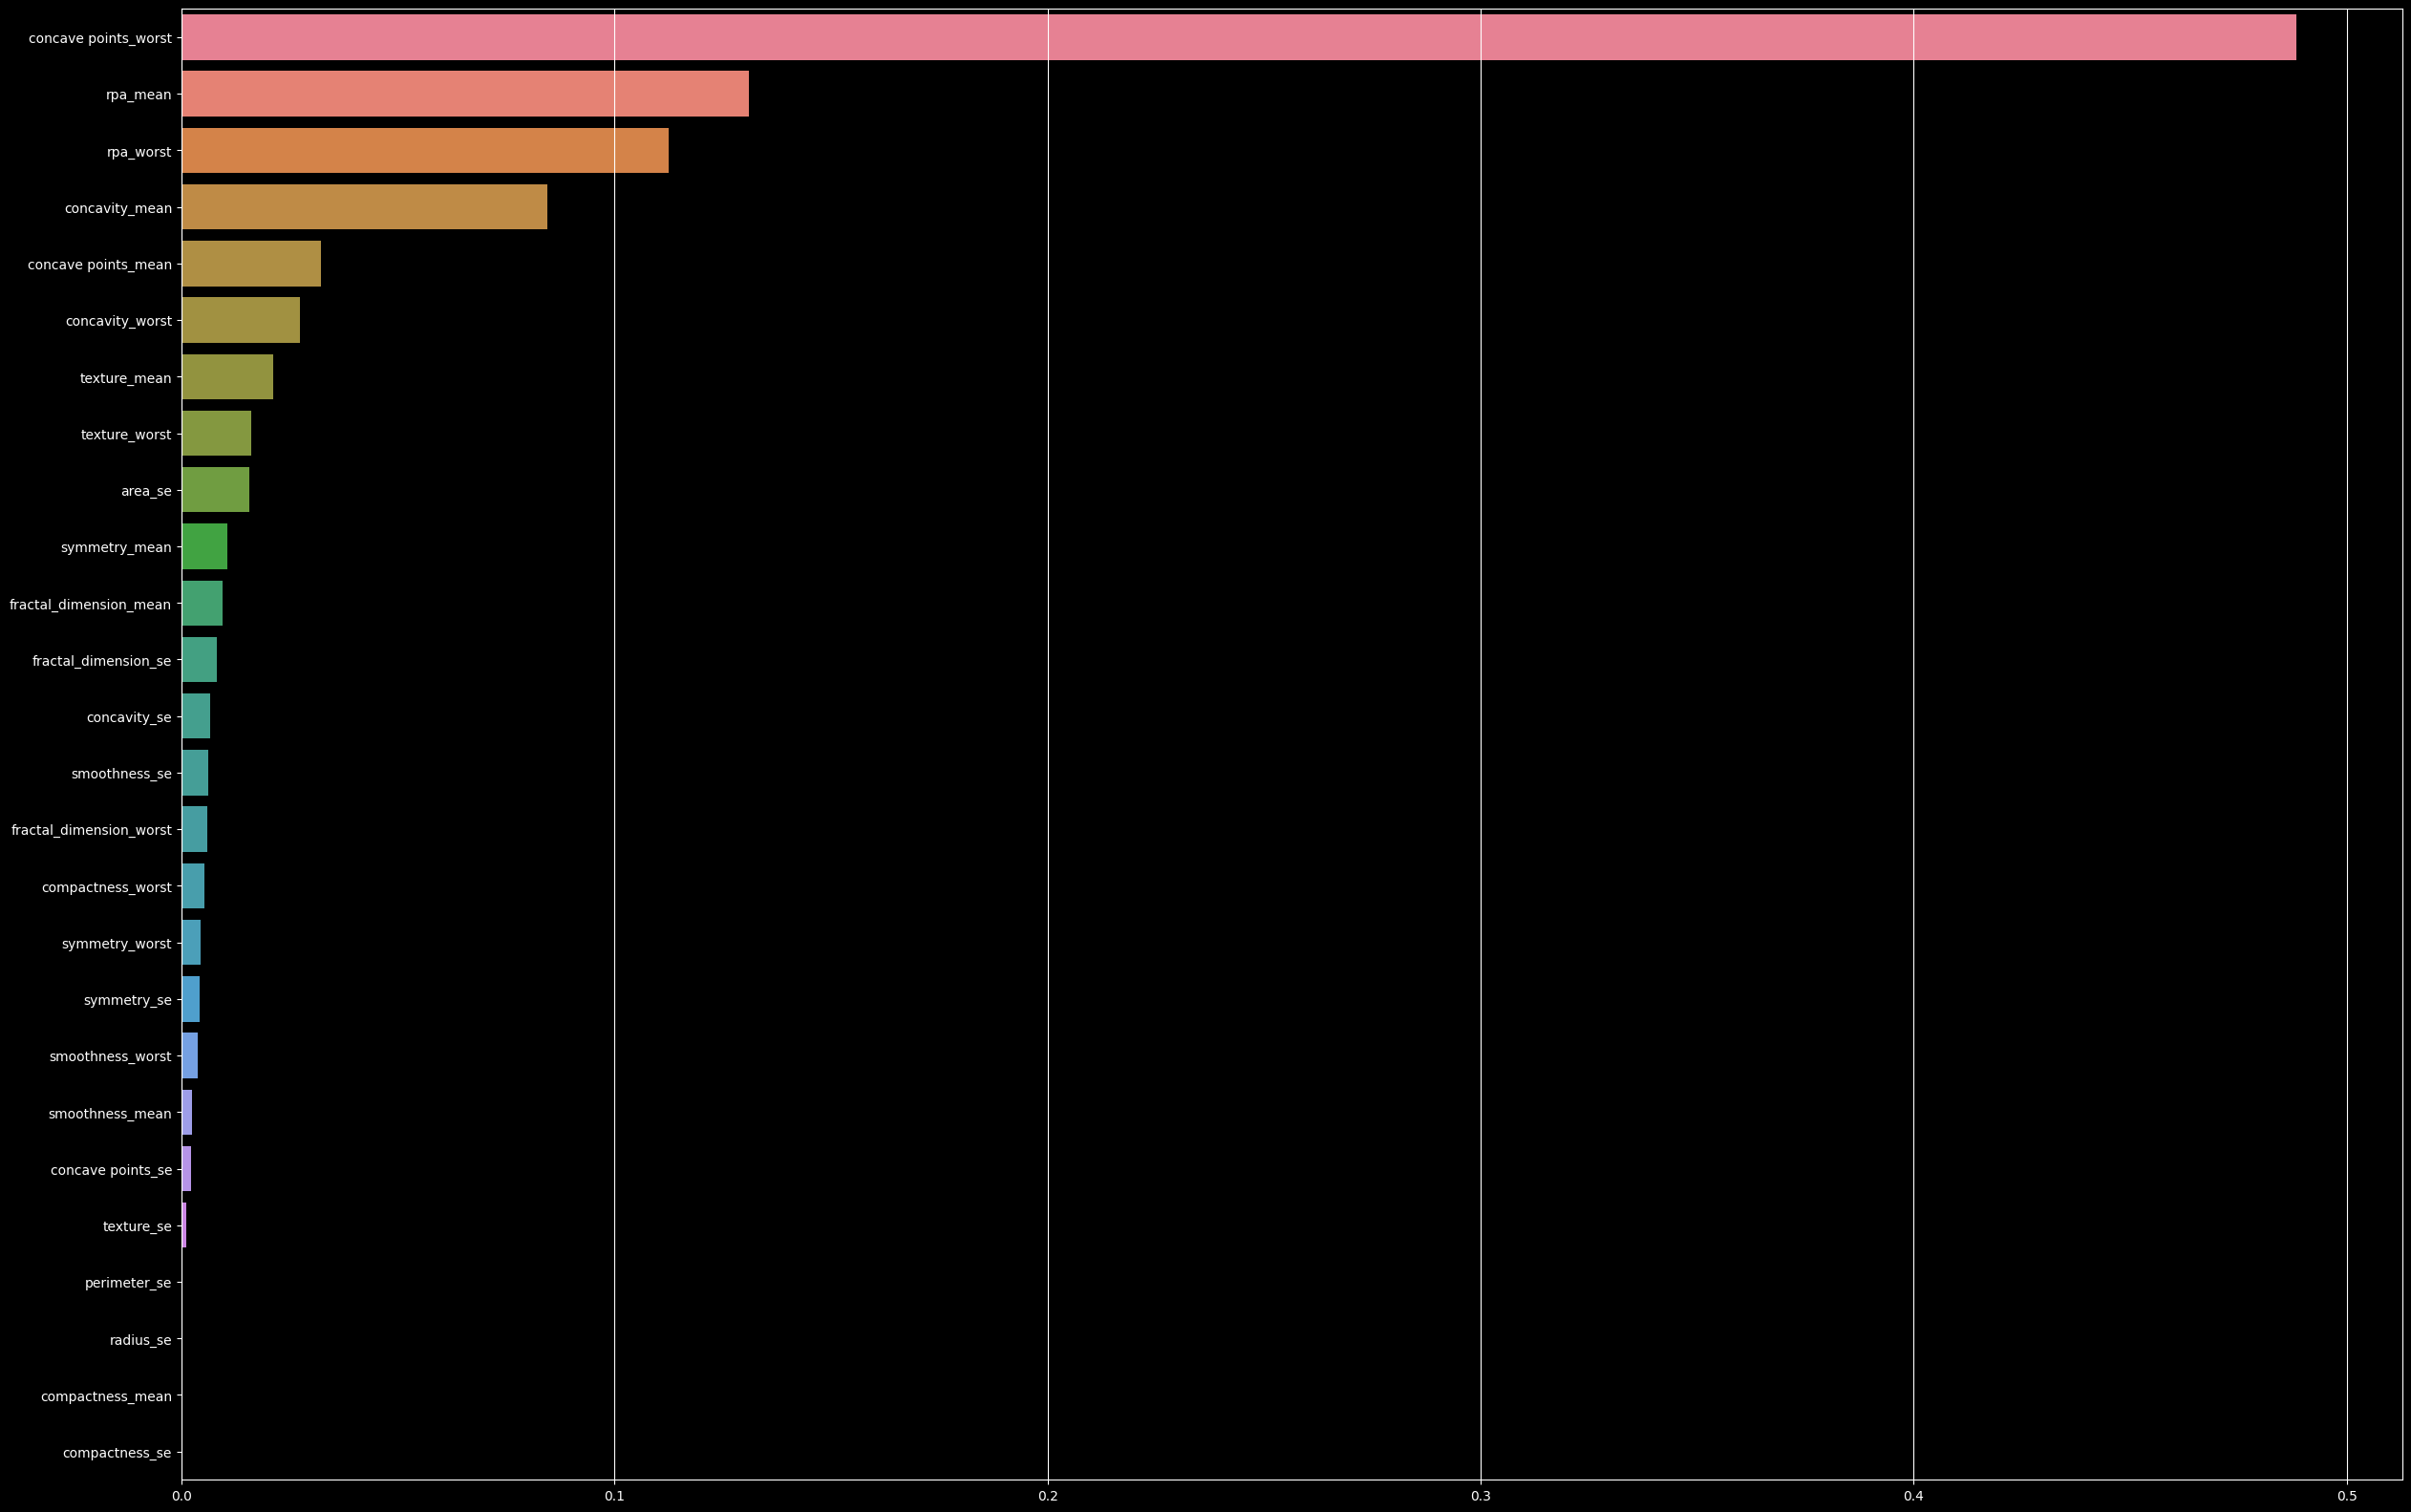

In [432]:
plt.figure(figsize=(30,20))
sns.barplot(data=xgbc_betas.T, orient="h")
plt.grid(axis="x", c="white")
plt.show()

## Neural Networks

In [433]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"We are currently using device: {device}")

We are currently using device: cuda


In [434]:
class CancerDataset(data.Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X.values, dtype=torch.float32)
    self.y = torch.tensor(y.values, dtype=torch.float32)

  def __str__(self) -> str:
    return f"CancerDataset with {len(self)} samples"

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.y[index]

In [435]:
train_medium = CancerDataset(X_train, y_train_num)
val_medium = CancerDataset(X_val, y_val_num)
test_medium = CancerDataset(X_test, y_test_num)

In [436]:
train_nn = data.DataLoader(train_medium, batch_size=32, shuffle=True)
val_nn = data.DataLoader(val_medium, batch_size=32, shuffle=True)
test_nn = data.DataLoader(test_medium, batch_size=32, shuffle=True)

In [437]:
print(len(train_nn), "|", X.shape)

14 | (569, 30)


In [438]:
class BCancerDetector(nn.Module):
  def __init__(self) -> None:
    super(BCancerDetector, self).__init__()

    self.layer_1 = nn.Linear(X_train.shape[1], 64)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.2)
    self.layer_2 = nn.Linear(64, 32)
    self.layer_3 = nn.Linear(32, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.layer_1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.layer_2(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.layer_3(x)
    x = self.sigmoid(x)
    return x


In [439]:
summary(BCancerDetector().to(device), (X_train.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,728
              ReLU-2                   [-1, 64]               0
           Dropout-3                   [-1, 64]               0
            Linear-4                   [-1, 32]           2,080
              ReLU-5                   [-1, 32]               0
           Dropout-6                   [-1, 32]               0
            Linear-7                    [-1, 1]              33
           Sigmoid-8                    [-1, 1]               0
Total params: 3,841
Trainable params: 3,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


In [440]:
# Instantiate the model, loss function, and optimizer
model = BCancerDetector().to(device)
criterion = nn.BCELoss() # Binary Cross-Entropy Loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimizer

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train() # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in train_nn:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1)) # Add unsqueeze(1) to match shape

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    if (epoch+1) % 10 == 0:
      print(f"Epoch {epoch+1}/{num_epochs} | Training Loss: {(running_loss / len(train_medium)):.4f}")

    model.eval()
    with torch.no_grad():
        val_running_loss = 0.0
        for val_inputs, val_labels in val_nn:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels.unsqueeze(1))
            val_running_loss += val_loss.item() * val_inputs.size(0)
        val_epoch_loss = val_running_loss / len(val_medium)
        if (epoch+1) % 10 == 0:
          print(f"Epoch {epoch+1}/{num_epochs} | Validation Loss: {val_epoch_loss:.4f}")
          print("="*38)

print("Training finished!")

Epoch 10/100 | Training Loss: 0.0518
Epoch 10/100 | Validation Loss: 0.0419
Epoch 20/100 | Training Loss: 0.0235
Epoch 20/100 | Validation Loss: 0.0195
Epoch 30/100 | Training Loss: 0.0162
Epoch 30/100 | Validation Loss: 0.0131
Epoch 40/100 | Training Loss: 0.0113
Epoch 40/100 | Validation Loss: 0.0101
Epoch 50/100 | Training Loss: 0.0096
Epoch 50/100 | Validation Loss: 0.0070
Epoch 60/100 | Training Loss: 0.0058
Epoch 60/100 | Validation Loss: 0.0075
Epoch 70/100 | Training Loss: 0.0031
Epoch 70/100 | Validation Loss: 0.0045
Epoch 80/100 | Training Loss: 0.0069
Epoch 80/100 | Validation Loss: 0.0058
Epoch 90/100 | Training Loss: 0.0030
Epoch 90/100 | Validation Loss: 0.0046
Epoch 100/100 | Training Loss: 0.0088
Epoch 100/100 | Validation Loss: 0.0052
Training finished!


In [441]:
threshold = 0.75

In [442]:
nn_y_preds = []
nn_y_probas = []
nn_y_val = []
with torch.no_grad():
  model.eval()
  for inputs, labels in val_nn:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    nn_y_preds.append((outputs > threshold).cpu().numpy())
    nn_y_probas.append(outputs.cpu().numpy())
    nn_y_val.append(labels.cpu().numpy())

nn_y_preds = np.concatenate(nn_y_preds)
nn_y_probas = np.concatenate(nn_y_probas)
nn_y_val = np.concatenate(nn_y_val)

In [443]:
nn_y_val = nn_y_val.astype(int)

In [444]:
nn_y_val

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0])

In [445]:
nn_y_preds = nn_y_preds.flatten().astype(int)

In [446]:
for value in nn_y_probas.flatten():
  if 0.9 < value < 1:
    print(f"{value:.4f}")

0.9938
1.0000
1.0000
1.0000
0.9925
0.9998
0.9691
1.0000
0.9993
1.0000
0.9997
1.0000
1.0000
0.9977


In [447]:
nn_conf_matrix = model_evaluation_num(nn_y_val, nn_y_preds, nn_y_probas)

Validation Precision: 1.0000
Validation Recall: 1.0000
Validation F1-score: 1.0000
Validation BinaryCrossEntropy Loss: 0.0052

Confusion Matrix:
[[69  0]
 [ 0 74]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00        69

    accuracy                           1.00       143
   macro avg       1.00      1.00      1.00       143
weighted avg       1.00      1.00      1.00       143



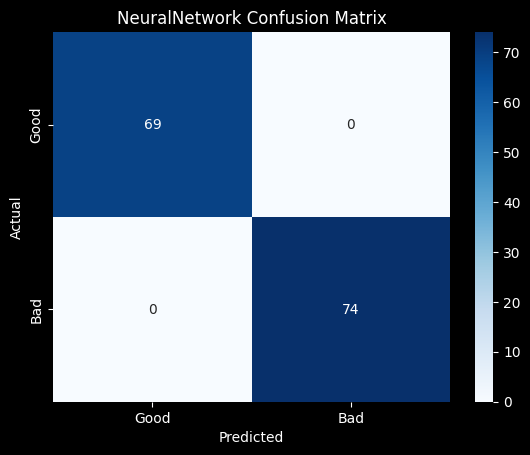

In [448]:
confusion_matrix_heatmap(nn_conf_matrix, "NeuralNetwork Confusion Matrix")

# Testing with Unseen Data
No takebacksies from here, after I evaluate the test set my hands are tied and no more modelling.

In [449]:
X_test

,texture_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,...,fractal_dimension_se,texture_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,rpa_mean,rpa_worst
0,-0.823945,-0.243370,-1.249839,-1.207829,-1.311811,0.211122,-0.076267,-0.868788,-0.442776,-0.922268,...,-0.537106,-0.782481,-0.277700,-1.239268,-1.300368,-1.604394,-0.453546,-0.627140,-1.220482,-1.162830
1,0.400972,-0.281444,0.354382,0.305705,0.722003,1.006945,-1.028845,1.940492,-0.043648,1.779602,...,0.123554,0.366836,0.029231,0.276409,0.261518,0.772027,0.182046,-0.149178,1.326744,1.632175
2,-0.337270,-0.580064,-1.494072,-1.007455,-0.718891,-1.380524,-0.595576,-0.968729,2.063167,-1.020212,...,-0.917709,-0.608494,-1.699060,-1.511546,-1.278305,-1.209000,-1.587481,-1.313931,-0.561151,-0.811901
3,-0.537112,-0.673382,-1.186394,-0.978886,-0.924483,-0.870283,-0.518755,-0.939690,0.628856,-0.920688,...,-0.971884,1.651663,0.480599,-0.763572,-0.625906,-0.655418,0.023557,-0.433945,-0.961531,-0.836129
4,-0.259684,0.739090,0.020252,-0.795576,-0.661685,-0.405736,0.101957,-0.908765,-1.099242,-0.876456,...,-0.913118,-0.215350,1.252439,0.204841,-0.211677,0.181640,0.914039,0.079752,-0.432566,-0.414780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,-1.225981,0.017176,0.801877,-0.226126,-0.731631,0.275854,4.193433,0.322205,-0.652000,0.031891,...,8.334749,-1.802981,-0.629767,-0.238746,-0.811155,-1.243101,-1.151227,1.294200,-1.512038,-1.399720
139,0.792160,0.280273,1.241270,0.662948,0.612604,-0.424996,0.313046,-0.518882,-0.241607,0.192868,...,0.131514,0.336873,-0.140904,0.844835,0.576189,0.536536,-0.080381,-0.080567,-0.042476,-0.204691
140,-0.052788,-0.531538,-0.992480,-0.581370,-0.590239,-0.881707,-0.890568,0.109123,-0.114726,0.018200,...,-0.875930,0.572609,0.245887,-0.812573,-0.216590,-0.219463,-0.121862,-0.642774,-0.443746,0.049594
141,-1.209523,0.091085,-0.421476,-0.875726,-0.940221,-0.748435,1.159011,-0.387564,2.367525,-0.375681,...,1.369121,-1.165587,0.060826,-0.754546,-1.163864,-1.350062,-0.857122,-0.019078,-1.217098,-1.204724


In [450]:
log_test_preds = logistician.predict(X_test)
log_test_probas = logistician.predict_proba(X_test)

In [454]:
# Convert Logistic Regression predictions from strings ('B', 'M') to integers (0, 1)
log_test_preds_num = np.where(log_test_preds == 'B', 0, 1)

log_test_confusion = model_evaluation_num(y_test_num, log_test_preds_num, log_test_probas)

Validation Precision: 0.9600
Validation Recall: 0.9600
Validation F1-score: 0.9600
Validation BinaryCrossEntropy Loss: 0.1744

Confusion Matrix:
[[65  3]
 [ 3 72]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        75
           1       0.96      0.96      0.96        68

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



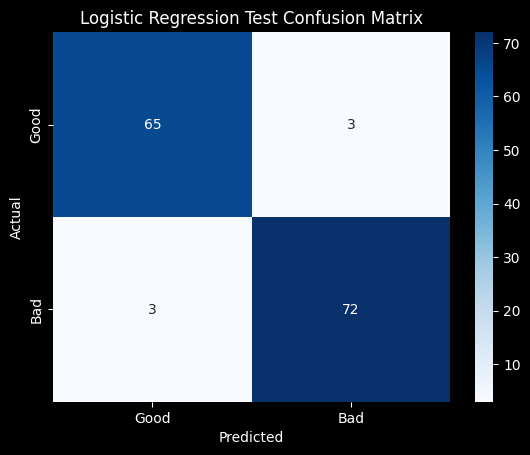

In [455]:
confusion_matrix_heatmap(log_test_confusion, "Logistic Regression Test Confusion Matrix")

In [458]:
forest_test_preds = forest.predict(X_test)
forest_test_probas = forest.predict_proba(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    0.0s finished


In [461]:
def change_to_numerical(y_preds):
  y_preds_num = np.where(y_preds == 'B', 0, 1)
  return y_preds_num

In [462]:
forest_test_preds_num = change_to_numerical(forest_test_preds)

forest_test_confusion = model_evaluation_num(y_test_num, forest_test_preds_num, forest_test_probas)

Validation Precision: 0.9487
Validation Recall: 0.9867
Validation F1-score: 0.9673
Validation BinaryCrossEntropy Loss: 0.1500

Confusion Matrix:
[[64  4]
 [ 1 74]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        75
           1       0.98      0.94      0.96        68

    accuracy                           0.97       143
   macro avg       0.97      0.96      0.96       143
weighted avg       0.97      0.97      0.96       143



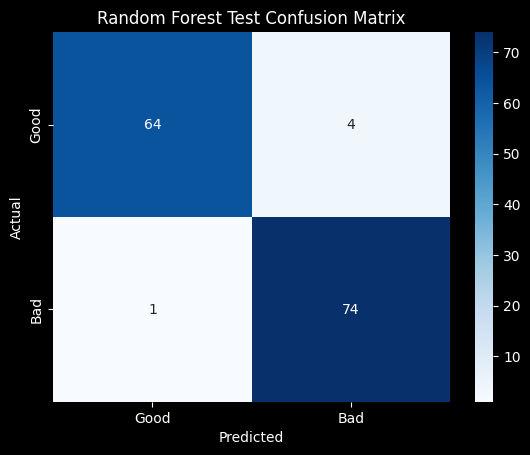

In [464]:
confusion_matrix_heatmap(forest_test_confusion, "Random Forest Test Confusion Matrix")

In [465]:
svm_test_preds = svm.predict(X_test)
svm_test_probas = svm.predict_proba(X_test)

In [466]:
svm_test_preds_num = change_to_numerical(svm_test_preds)

svm_test_confusion = model_evaluation_num(y_test_num, svm_test_preds_num, svm_test_probas)

Validation Precision: 0.9359
Validation Recall: 0.9733
Validation F1-score: 0.9542
Validation BinaryCrossEntropy Loss: 0.1222

Confusion Matrix:
[[63  5]
 [ 2 73]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        75
           1       0.97      0.93      0.95        68

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143



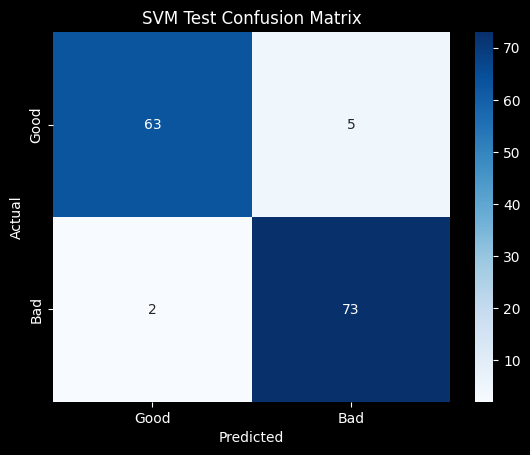

In [467]:
confusion_matrix_heatmap(svm_test_confusion, "SVM Test Confusion Matrix")

In [468]:
xgbc_test_preds = xgbc.predict(X_test)
xgbc_test_probas = xgbc.predict_proba(X_test)

In [471]:
xgbc_test_confusion = xgbc_test_confusion = model_evaluation_num(y_test_num, xgbc_test_preds, xgbc_test_probas)

Validation Precision: 0.9605
Validation Recall: 0.9733
Validation F1-score: 0.9669
Validation BinaryCrossEntropy Loss: 0.1256

Confusion Matrix:
[[65  3]
 [ 2 73]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        75
           1       0.97      0.96      0.96        68

    accuracy                           0.97       143
   macro avg       0.97      0.96      0.96       143
weighted avg       0.97      0.97      0.97       143



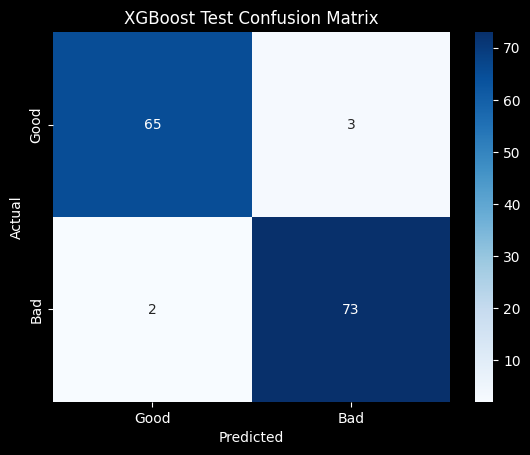

In [472]:
confusion_matrix_heatmap(xgbc_test_confusion, "XGBoost Test Confusion Matrix")

In [479]:
nn_test_preds = []
nn_test_probas = []
nn_y_test = [] # Variable to store the true labels from the test set

with torch.no_grad():
  model.eval()
  for inputs, labels in test_nn: # Use test_nn DataLoader
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    nn_test_preds.append((outputs > threshold).cpu().numpy()) # Use the threshold determined from validation
    nn_test_probas.append(outputs.cpu().numpy())
    nn_y_test.append(labels.cpu().numpy()) # Collect true labels from the test set

nn_test_preds = np.concatenate(nn_test_preds)
nn_test_probas = np.concatenate(nn_test_probas)
nn_y_test = np.concatenate(nn_y_test)

In [480]:
nn_y_test = nn_y_test.astype(int) # Ensure true labels are integers
nn_test_preds_int = nn_test_preds.flatten().astype(int) # Ensure predictions are integers

nn_test_confusion = model_evaluation_num(nn_y_test, nn_test_preds_int, nn_test_probas)

Validation Precision: 0.9600
Validation Recall: 0.9600
Validation F1-score: 0.9600
Validation BinaryCrossEntropy Loss: 0.2462

Confusion Matrix:
[[65  3]
 [ 3 72]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        75
           1       0.96      0.96      0.96        68

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143



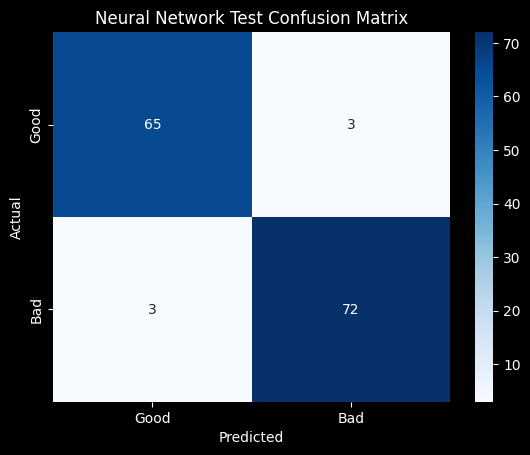

In [481]:
confusion_matrix_heatmap(nn_test_confusion, "Neural Network Test Confusion Matrix")

# Conclusion
Basically Tree models did bad on the validation set, but they are surprisingly good at extrapolating and predicting new data!

The worst performer was the Support Vector Machine here, probably due to overfitting to the training and validation data a bit...

Logistic Regression and the Neural Network surprisingly had the same confusion matrix, although the Neural Network had a much higher BCELoss than any of them, even though it had over 3000 learnable parameters.

Just use Random Forests for everything, it gets the job done and it's interpretable enough!

In [507]:
eval_metrics = pd.DataFrame({
    "Precision": [0.9600, 0.9487, 0.9359, 0.9605, 0.9600],
    "Recall": [0.9600, 0.9867, 0.9733, 0.9733, 0.9600],
    "F1-Score": [0.9600, 0.9673, 0.9542, 0.9669, 0.9600],
    "BCE Loss": [0.1744, 0.1500, 0.1222, 0.1256, 0.2462]
}, index=["Logistic Regression", "Random Forest", "SVM", "XGBoost", "Neural Network"])

display(eval_metrics)

,Precision,Recall,F1-Score,BCE Loss
Logistic Regression,0.9600,0.9600,0.9600,0.1744
Random Forest,0.9487,0.9867,0.9673,0.1500
SVM,0.9359,0.9733,0.9542,0.1222
XGBoost,0.9605,0.9733,0.9669,0.1256
Neural Network,0.9600,0.9600,0.9600,0.2462


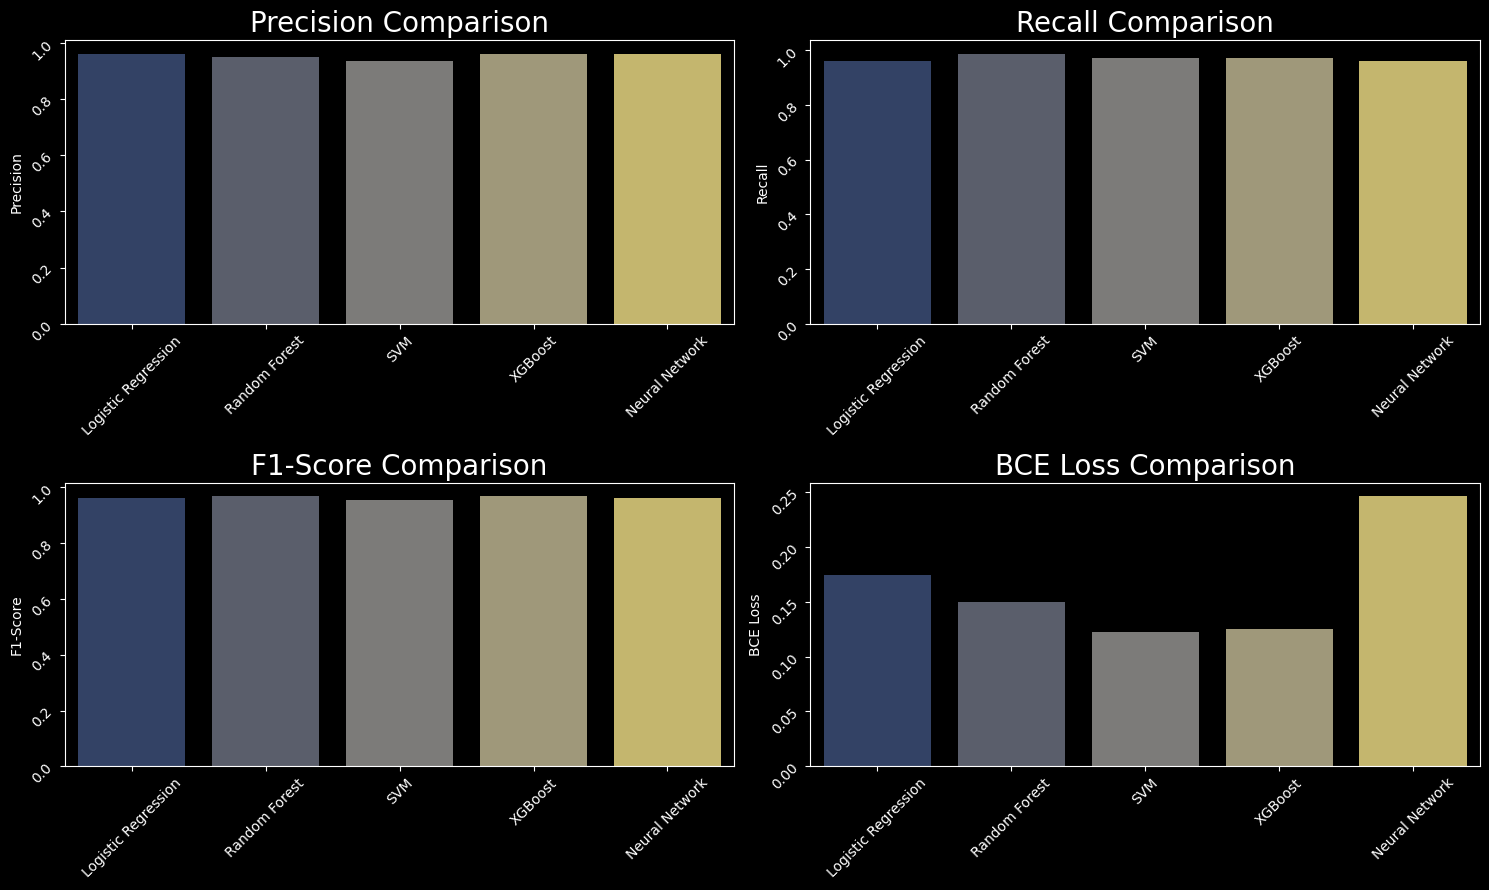

In [521]:
fig, axes = plt.subplots(2, 2, figsize=(15,9))
axes = axes.flatten()

for idx, column in enumerate(list(eval_metrics.columns)):
  sns.barplot(data=eval_metrics, x=eval_metrics.index, y=column, ax=axes[idx], palette="cividis", hue=eval_metrics.index)
  axes[idx].set_xlabel("")
  axes[idx].set_title(f"{column} Comparison", size=20)
  axes[idx].tick_params(rotation=45)

plt.tight_layout()
plt.show()